In [1]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from keijzer import *
import math

In [2]:
data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2020.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
#dat_source1 = dat_source1.iloc[:-3,:]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2021.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:8761,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2022.csv'
data_source3 = pd.read_csv(data_path)
dat_source3 = pd.DataFrame(data_source3)
dat_source3 = dat_source3.iloc[:8760,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2023.csv'
data_source4 = pd.read_csv(data_path)
dat_source4 = pd.DataFrame(data_source4)
dat_source4 = dat_source4.iloc[:8760,:9]

dat_arr1 = np.array(dat_source1)
dat_arr2 = np.array(dat_source2)
dat_arr3 = np.array(dat_source3)
dat_arr4 = np.array(dat_source4)

dat_arr = np.concatenate([dat_arr1, dat_arr2, dat_arr3, dat_arr4],axis=0)
dat_arr.shape # 8784, 8761, 8760, 8760

dat_source = pd.DataFrame(dat_arr, columns=['Time-Date stamp','Date','ERCOT Load','Total Wind Output','Total Wind Installed','Wind Output, % of Load','Wind Output, % of Installed','1-hr MW change','1-hr % change'])
dat_source

,Time-Date stamp,Date,ERCOT Load,Total Wind Output,Total Wind Installed,"Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
35060,12-31-2023 20:00:00,Dec-31,44887,17161,38631,38.23,44.42,2858,19.99
35061,12-31-2023 21:00:00,Dec-31,44013,18301,38631,41.58,47.37,1139,6.64
35062,12-31-2023 22:00:00,Dec-31,43280,18607,38631,42.99,48.17,307,1.67
35063,12-31-2023 23:00:00,Dec-31,42319,17866,38631,42.22,46.25,-741,-3.98


In [3]:
dat = pd.DataFrame()
dat['Timestamp'] = np.array(dat_source['Time-Date stamp'].iloc[1:])
dat['MW % change'] = np.array(dat_source.iloc[1:,3], dtype=float)-np.array(dat_source.iloc[0:-1,3], dtype=float)
dat['MW % change'] = np.divide(np.array(dat['MW % change']),np.array(dat_source.iloc[1:,4]))*100
dat['Total Wind Output'] = np.divide(np.array(dat_source.iloc[1:,3]), np.array(dat_source.iloc[1:,4]))

ramp_ratio = 20
load_ratio = 10
year_arr = np.concatenate([np.ones(8784)*2020, np.ones(8760)*2021, np.ones(8760)*2022, np.ones(8760)*2023])
year_df = pd.DataFrame(year_arr, columns=['Year'], dtype=int)
wind_df = pd.concat([year_df, dat], axis=1)
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35054,2023,12-31-2023 15:00:00,0.906008,0.224535
35055,2023,12-31-2023 16:00:00,1.3383,0.237918
35056,2023,12-31-2023 17:00:00,2.27279,0.260646
35057,2023,12-31-2023 18:00:00,2.26243,0.28327
35058,2023,12-31-2023 19:00:00,8.69768,0.370247
35059,2023,12-31-2023 20:00:00,7.3982,0.444229
35060,2023,12-31-2023 21:00:00,2.951,0.473739
35061,2023,12-31-2023 22:00:00,0.79211,0.48166
35062,2023,12-31-2023 23:00:00,-1.91815,0.462478
35063,2023,01-01-2024 00:00:00,-5.16942,0.410784


In [4]:
import sklearn

wind_df = wind_df.reset_index(drop=True)

std_scaler = sklearn.preprocessing.MinMaxScaler()
std_scaler_load = sklearn.preprocessing.MinMaxScaler()
std_scaler_ramp = sklearn.preprocessing.MinMaxScaler()

wind_df[['Total Wind Output']] = std_scaler.fit_transform(wind_df[['Total Wind Output']])
wind_df[['MW % change']] = std_scaler_ramp.fit_transform(wind_df[['MW % change']])
#wind_df[['Wind Change, % of Load', 'Wind Change']] = std_scaler_ramp.fit_transform(wind_df[['Wind Change, % of Load', 'Wind Change']])
wind_df = wind_df.iloc[:-1,:]
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35053,2023,12-31-2023 14:00:00,0.475470,0.281695
35054,2023,12-31-2023 15:00:00,0.540013,0.293595
35055,2023,12-31-2023 16:00:00,0.553030,0.311174
35056,2023,12-31-2023 17:00:00,0.581170,0.341026
35057,2023,12-31-2023 18:00:00,0.580858,0.370742
35058,2023,12-31-2023 19:00:00,0.774643,0.484984
35059,2023,12-31-2023 20:00:00,0.735512,0.582157
35060,2023,12-31-2023 21:00:00,0.601593,0.620917
35061,2023,12-31-2023 22:00:00,0.536583,0.631322
35062,2023,12-31-2023 23:00:00,0.454969,0.606127


In [5]:
dat_source1

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
8779,12-31-2020 19:00:00,Dec-31,49857,15165,31090,30.4,48.777,788.4,5.484
8780,12-31-2020 20:00:00,Dec-31,48800,15706,31090,32.2,50.517,540.8,3.566
8781,12-31-2020 21:00:00,Dec-31,47848,15079,31090,31.5,48.502,-626.4,-3.989
8782,12-31-2020 22:00:00,Dec-31,46123,14995,31090,32.5,48.231,-84.1,-0.558


In [6]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/training_result_df_fh6.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/training_ramp_result_df_fh6.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

dat_source = pd.concat([dat_source1, dat_source2], axis=1)
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value
0,0.820358,0.810277,-0.010081,0.877295,0.384768,0.473157,0.088390,0.350890
1,0.810682,0.786363,-0.024319,0.878565,0.377150,0.457903,0.080753,0.416697
2,0.878174,0.861144,-0.017030,0.831325,0.650192,0.684175,0.033983,0.515013
3,0.834351,0.818281,-0.016070,0.818599,0.472766,0.414461,-0.058305,0.527658
4,0.767026,0.770934,0.003908,0.770386,0.432480,0.404181,-0.028298,0.373102
...,...,...,...,...,...,...,...,...
188173,0.614230,0.614378,0.000148,0.604920,0.499278,0.480200,-0.019078,0.613361
188174,0.556005,0.539389,-0.016616,0.606330,0.352467,0.340809,-0.011658,0.484342
188175,0.456125,0.443658,-0.012467,0.591666,0.316965,0.293253,-0.023712,0.427878
188176,0.454104,0.409876,-0.044228,0.585936,0.511257,0.435282,-0.075976,0.398752


In [7]:
pred = np.array(dat_source[['Predicted_Value']])
rpred = np.array(dat_source[['Ramp_Predicted_Value']])

real_value = np.array(dat_source[['Predicted_Value']])+np.array(dat_source[['Forecasting_Error']])
real_ramp_value = np.array(dat_source[['Ramp_Predicted_Value']])+np.array(dat_source[['Ramp_Forecasting_Error']])

dat_source['Real_Value'] = real_value
dat_source['Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Initial_Predicted_Value']])
dat_source['Real_Ramp_Value'] = real_ramp_value
dat_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Ramp_Initial_Predicted_Value']])
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.820358,0.810277,-0.010081,0.877295,0.384768,0.473157,0.088390,0.350890,-0.067018,0.473157,0.459387
1,0.810682,0.786363,-0.024319,0.878565,0.377150,0.457903,0.080753,0.416697,-0.092202,0.457903,0.369666
2,0.878174,0.861144,-0.017030,0.831325,0.650192,0.684175,0.033983,0.515013,0.029819,0.684175,0.346131
3,0.834351,0.818281,-0.016070,0.818599,0.472766,0.414461,-0.058305,0.527658,-0.000318,0.414461,0.290623
4,0.767026,0.770934,0.003908,0.770386,0.432480,0.404181,-0.028298,0.373102,0.000548,0.404181,0.397832
...,...,...,...,...,...,...,...,...,...,...,...
188173,0.614230,0.614378,0.000148,0.604920,0.499278,0.480200,-0.019078,0.613361,0.009458,0.480200,0.001017
188174,0.556005,0.539389,-0.016616,0.606330,0.352467,0.340809,-0.011658,0.484342,-0.066941,0.340809,0.055048
188175,0.456125,0.443658,-0.012467,0.591666,0.316965,0.293253,-0.023712,0.427878,-0.148009,0.293253,0.015780
188176,0.454104,0.409876,-0.044228,0.585936,0.511257,0.435282,-0.075976,0.398752,-0.176060,0.435282,0.011124


In [8]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/test_result_df_fh6.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/test_ramp_result_df_fh6.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

test_source = pd.concat([dat_source1, dat_source2], axis=1)
ini_test_source = pd.DataFrame(test_source)

pred = np.array(test_source[['Predicted_Value']])
rpred = np.array(test_source[['Ramp_Predicted_Value']])

real_value = np.array(test_source[['Predicted_Value']])+np.array(test_source[['Forecasting_Error']])
real_ramp_value = np.array(test_source[['Ramp_Predicted_Value']])+np.array(test_source[['Ramp_Forecasting_Error']])

test_source['Real_Value'] = real_value
test_source['Initial_Forecasting_Error'] = real_value-np.array(test_source[['Initial_Predicted_Value']])
test_source['Real_Ramp_Value'] = real_ramp_value
test_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(test_source[['Ramp_Initial_Predicted_Value']])
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.820593,0.680965,-0.139628,0.733506,0.261410,0.457501,0.196092,0.362844,-0.052541,0.457501,0.318121
1,0.855535,0.666532,-0.189003,0.738617,0.312076,0.479641,0.167565,0.380962,-0.072085,0.479641,0.285570
2,0.854748,0.672249,-0.182498,0.714351,0.465822,0.525838,0.060016,0.429176,-0.042102,0.525838,0.243073
3,0.848693,0.654993,-0.193701,0.698448,0.516788,0.473167,-0.043622,0.465008,-0.043455,0.473167,0.189985
4,0.836174,0.656945,-0.179230,0.678319,0.637684,0.517206,-0.120479,0.468105,-0.021374,0.517206,0.188840
...,...,...,...,...,...,...,...,...,...,...,...
20383,0.302934,0.293595,-0.009339,0.363416,0.461915,0.540013,0.078097,0.451135,-0.069821,0.540013,-0.157539
20384,0.326586,0.311174,-0.015413,0.396363,0.521122,0.553030,0.031908,0.468566,-0.085189,0.553030,-0.157393
20385,0.393312,0.341026,-0.052286,0.433449,0.573963,0.581170,0.007207,0.474114,-0.092424,0.581170,-0.133088
20386,0.438926,0.370742,-0.068184,0.469232,0.730149,0.580858,-0.149291,0.548159,-0.098490,0.580858,-0.177417


### Plotting Histograms

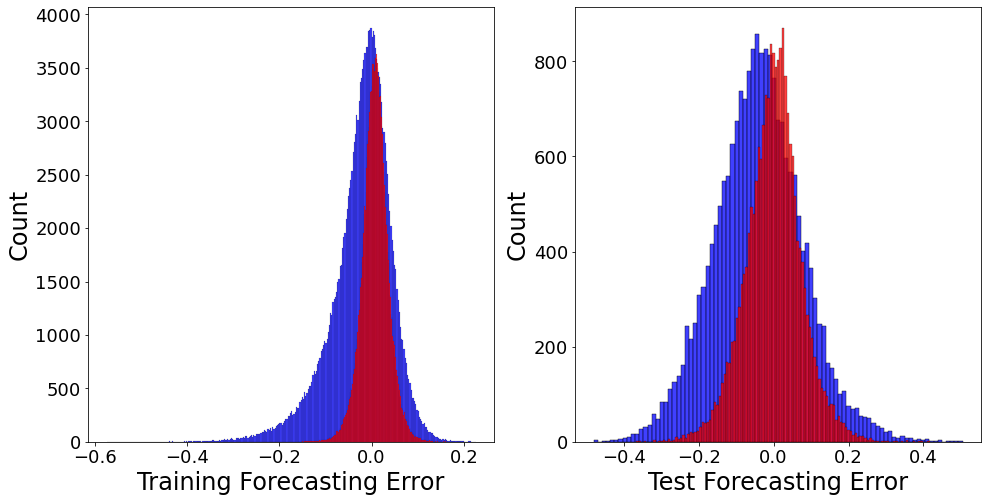

In [13]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

#f.savefig('GenError_Histogram_FFEL_lead.png', dpi=800, bbox_inches="tight")

In [14]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

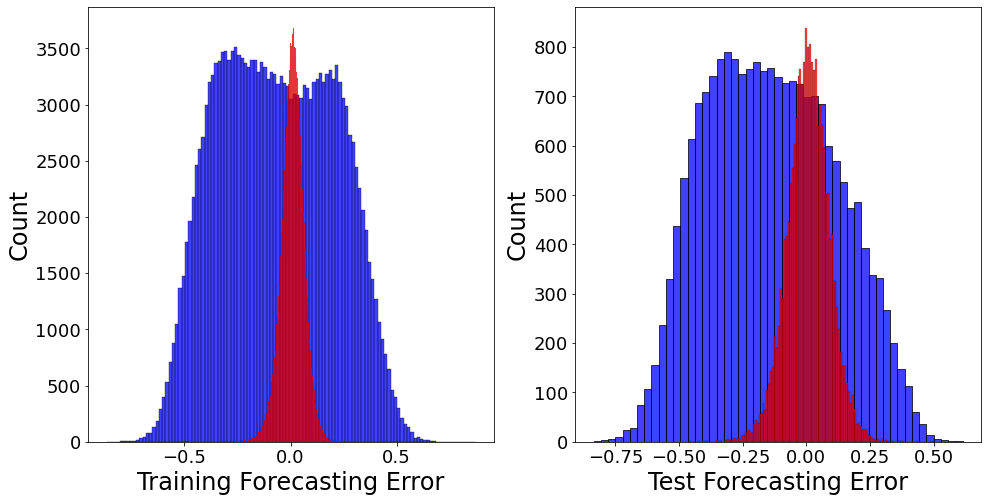

In [15]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Ramp_Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Ramp_Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

#f.savefig('RampError_Histogram_FFEL_lead.png', dpi=800, bbox_inches="tight")

In [16]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

## Training/Test Datset Construction

In [9]:
times = np.zeros(dat_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

dat_source['time'] = times
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.820358,0.810277,-0.010081,0.877295,0.384768,0.473157,0.088390,0.350890,-0.067018,0.473157,0.459387,0
1,0.810682,0.786363,-0.024319,0.878565,0.377150,0.457903,0.080753,0.416697,-0.092202,0.457903,0.369666,1
2,0.878174,0.861144,-0.017030,0.831325,0.650192,0.684175,0.033983,0.515013,0.029819,0.684175,0.346131,2
3,0.834351,0.818281,-0.016070,0.818599,0.472766,0.414461,-0.058305,0.527658,-0.000318,0.414461,0.290623,3
4,0.767026,0.770934,0.003908,0.770386,0.432480,0.404181,-0.028298,0.373102,0.000548,0.404181,0.397832,4
...,...,...,...,...,...,...,...,...,...,...,...,...
188173,0.614230,0.614378,0.000148,0.604920,0.499278,0.480200,-0.019078,0.613361,0.009458,0.480200,0.001017,13
188174,0.556005,0.539389,-0.016616,0.606330,0.352467,0.340809,-0.011658,0.484342,-0.066941,0.340809,0.055048,14
188175,0.456125,0.443658,-0.012467,0.591666,0.316965,0.293253,-0.023712,0.427878,-0.148009,0.293253,0.015780,15
188176,0.454104,0.409876,-0.044228,0.585936,0.511257,0.435282,-0.075976,0.398752,-0.176060,0.435282,0.011124,16


In [10]:
times = np.zeros(test_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

test_source['time'] = times
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.820593,0.680965,-0.139628,0.733506,0.261410,0.457501,0.196092,0.362844,-0.052541,0.457501,0.318121,0
1,0.855535,0.666532,-0.189003,0.738617,0.312076,0.479641,0.167565,0.380962,-0.072085,0.479641,0.285570,1
2,0.854748,0.672249,-0.182498,0.714351,0.465822,0.525838,0.060016,0.429176,-0.042102,0.525838,0.243073,2
3,0.848693,0.654993,-0.193701,0.698448,0.516788,0.473167,-0.043622,0.465008,-0.043455,0.473167,0.189985,3
4,0.836174,0.656945,-0.179230,0.678319,0.637684,0.517206,-0.120479,0.468105,-0.021374,0.517206,0.188840,4
...,...,...,...,...,...,...,...,...,...,...,...,...
20383,0.302934,0.293595,-0.009339,0.363416,0.461915,0.540013,0.078097,0.451135,-0.069821,0.540013,-0.157539,7
20384,0.326586,0.311174,-0.015413,0.396363,0.521122,0.553030,0.031908,0.468566,-0.085189,0.553030,-0.157393,8
20385,0.393312,0.341026,-0.052286,0.433449,0.573963,0.581170,0.007207,0.474114,-0.092424,0.581170,-0.133088,9
20386,0.438926,0.370742,-0.068184,0.469232,0.730149,0.580858,-0.149291,0.548159,-0.098490,0.580858,-0.177417,10


In [11]:
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.820358,0.810277,-0.010081,0.877295,0.384768,0.473157,0.088390,0.350890,-0.067018,0.473157,0.459387,0
1,0.810682,0.786363,-0.024319,0.878565,0.377150,0.457903,0.080753,0.416697,-0.092202,0.457903,0.369666,1
2,0.878174,0.861144,-0.017030,0.831325,0.650192,0.684175,0.033983,0.515013,0.029819,0.684175,0.346131,2
3,0.834351,0.818281,-0.016070,0.818599,0.472766,0.414461,-0.058305,0.527658,-0.000318,0.414461,0.290623,3
4,0.767026,0.770934,0.003908,0.770386,0.432480,0.404181,-0.028298,0.373102,0.000548,0.404181,0.397832,4
...,...,...,...,...,...,...,...,...,...,...,...,...
188173,0.614230,0.614378,0.000148,0.604920,0.499278,0.480200,-0.019078,0.613361,0.009458,0.480200,0.001017,13
188174,0.556005,0.539389,-0.016616,0.606330,0.352467,0.340809,-0.011658,0.484342,-0.066941,0.340809,0.055048,14
188175,0.456125,0.443658,-0.012467,0.591666,0.316965,0.293253,-0.023712,0.427878,-0.148009,0.293253,0.015780,15
188176,0.454104,0.409876,-0.044228,0.585936,0.511257,0.435282,-0.075976,0.398752,-0.176060,0.435282,0.011124,16


In [12]:
pair_ini_source = dat_source[['Initial_Predicted_Value', 'Initial_Forecasting_Error', 'Ramp_Initial_Predicted_Value', 'Ramp_Initial_Forecasting_Error', 'time']]

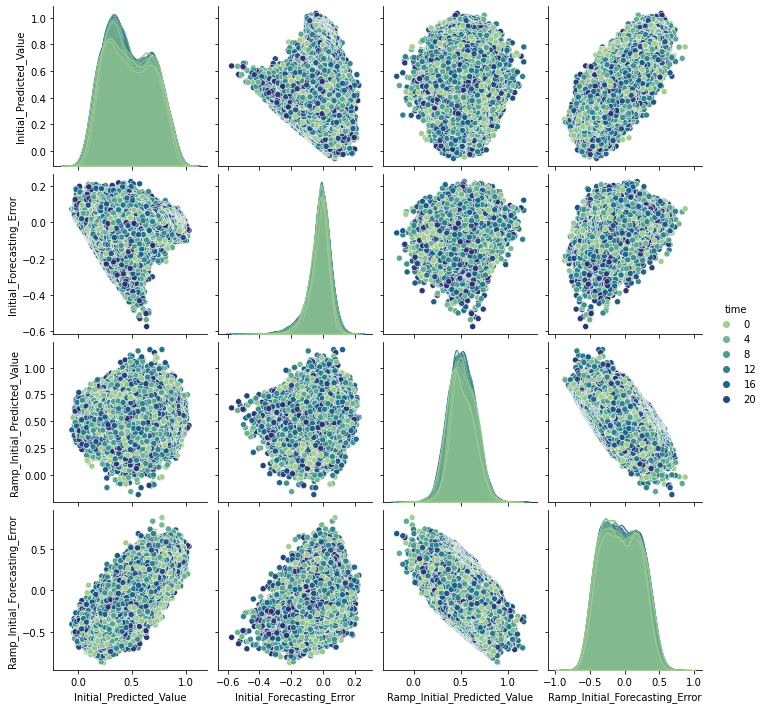

In [21]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_ini_source, palette="crest", hue='time')
#plt.savefig('pairplot_ini_with_time_lead.png', dpi=1000, bbox_inches="tight")

In [22]:
pair_source = dat_source[['Predicted_Value', 'Forecasting_Error', 'Ramp_Predicted_Value', 'Ramp_Forecasting_Error', 'time']]

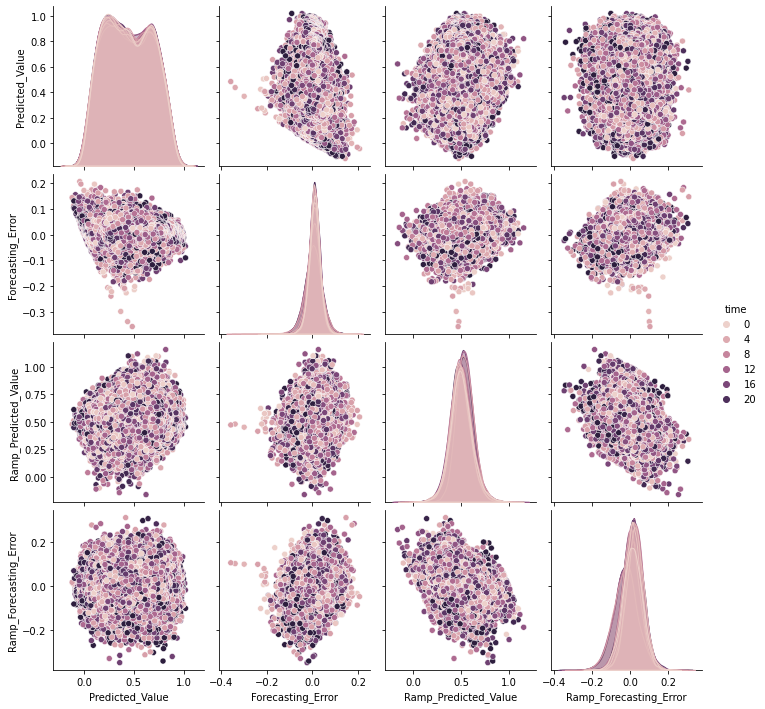

In [23]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_source, hue='time')
#plt.savefig('pairplot_with_time_lead.png', dpi=1000, bbox_inches="tight")

In [12]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square(y_true - y_pred))

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(abs(y_true - y_pred))

def maemd(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true-np.mean(y_true)))*100

def maems(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true))*100

In [13]:
tr_source = pd.DataFrame()
tr_source['Predicted_Value'] = dat_source['Predicted_Value']
tr_source['Real_Value'] = dat_source['Predicted_Value']+dat_source['Forecasting_Error']
tr_source['Ramp_Predicted_Value'] = dat_source['Ramp_Predicted_Value']
tr_source['Ramp_Real_Value'] = dat_source['Ramp_Predicted_Value']+dat_source['Ramp_Forecasting_Error']

times = np.zeros(tr_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

tr_source['time'] = times
normtr_source = np.array(tr_source)
normtr_source

array([[ 0.82035798,  0.81027721,  0.38476759,  0.47315716,  0.        ],
       [ 0.81068152,  0.78636261,  0.37715012,  0.45790282,  1.        ],
       [ 0.8781743 ,  0.86114395,  0.65019244,  0.68417546,  2.        ],
       ...,
       [ 0.45612499,  0.44365751,  0.31696495,  0.29325304, 15.        ],
       [ 0.45410377,  0.40987597,  0.51125729,  0.43528165, 16.        ],
       [ 0.44629401,  0.4949399 ,  0.51104087,  0.70774958, 17.        ]])

In [14]:
tr_source[['Predicted_Value']] = std_scaler.inverse_transform(tr_source[['Predicted_Value']])
tr_source[['Real_Value']] = std_scaler.inverse_transform(tr_source[['Real_Value']])

tr_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Predicted_Value']])
tr_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Real_Value']])
tr_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.625581,0.617906,-4.249416,-1.314147,0
1,0.618214,0.599699,-4.502379,-1.820718,1
2,0.669599,0.656633,4.564896,5.693415,2
3,0.636234,0.624000,-1.327144,-3.263343,3
4,0.584977,0.587952,-2.664984,-3.604728,4
...,...,...,...,...,...
188173,0.468647,0.468760,-0.446707,-1.080263,13
188174,0.424318,0.411668,-5.322076,-5.709205,14
188175,0.348275,0.338783,-6.501027,-7.288459,15
188176,0.346736,0.313064,-0.048906,-2.571929,16


In [15]:
trgen_pred = np.array(tr_source['Predicted_Value']).reshape(-1,6)
trgen_real = np.array(tr_source['Real_Value']).reshape(-1,6)
trram_pred = np.array(tr_source['Ramp_Predicted_Value']).reshape(-1,6)
trram_real = np.array(tr_source['Ramp_Real_Value']).reshape(-1,6)

trng_pred = np.array(normtr_source[:,0]).reshape(-1,6)
trnr_pred = np.array(normtr_source[:,2]).reshape(-1,6)

In [16]:
tgram = np.zeros(trgen_pred.shape)

for i in range(tgram.shape[0]):
    for j in range(tgram.shape[1]):
        if (i==0) & (j==0):
            gen0 = trgen_real[0,0]-trram_real[0,0]/100
        elif j==0:
            gen0 = trgen_real[i-1,0]
        else:
            gen0 = trgen_pred[i,j-1]
        
        tgram[i,j] = (trgen_pred[i,j]-gen0)*100

### Reconstruction of Original Dataset

In [17]:
t_source = pd.DataFrame()

In [18]:
t_source['Predicted_Value'] = ini_test_source['Predicted_Value']
t_source['Real_Value'] = ini_test_source['Predicted_Value']+ini_test_source['Forecasting_Error']
t_source['Ramp_Predicted_Value'] = ini_test_source['Ramp_Predicted_Value']
t_source['Ramp_Real_Value'] = ini_test_source['Ramp_Predicted_Value']+ini_test_source['Ramp_Forecasting_Error']

times = np.zeros(ini_test_source.shape[0])
for i in range(times.shape[0]):
    times[i] = int(i%24)

t_source['time'] = times

In [19]:
normt_source = np.array(t_source)
normt_source

array([[ 0.82059252,  0.68096495,  0.26140952,  0.45750109,  0.        ],
       [ 0.85553539,  0.66653197,  0.31207588,  0.47964061,  1.        ],
       [ 0.85474759,  0.67224938,  0.46582159,  0.52583787,  2.        ],
       ...,
       [ 0.39331153,  0.34102591,  0.57396334,  0.58117028,  9.        ],
       [ 0.43892595,  0.37074228,  0.73014939,  0.58085847, 10.        ],
       [ 0.51813489,  0.48498374,  0.75852978,  0.77464268, 11.        ]])

In [20]:
t_source[['Predicted_Value']] = std_scaler.inverse_transform(t_source[['Predicted_Value']])
t_source[['Real_Value']] = std_scaler.inverse_transform(t_source[['Real_Value']])

t_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Predicted_Value']])
t_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Real_Value']])
t_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.625760,0.519455,-8.345929,-1.834059,0.0
1,0.652363,0.508467,-6.663385,-1.098843,1.0
2,0.651763,0.512820,-1.557749,0.435290,2.0
3,0.647154,0.499681,0.134765,-1.313834,3.0
4,0.637623,0.501168,4.149525,0.148636,4.0
...,...,...,...,...,...
20383,0.231645,0.224535,-1.687474,0.906008,7.0
20384,0.249652,0.237918,0.278693,1.338303,8.0
20385,0.300453,0.260646,2.033456,2.272786,9.0
20386,0.335181,0.283270,7.220131,2.262432,10.0


## Combination of Two Forecasting Results

In [21]:
gen_pred = np.array(t_source['Predicted_Value']).reshape(-1,6)
gen_real = np.array(t_source['Real_Value']).reshape(-1,6)
ram_pred = np.array(t_source['Ramp_Predicted_Value']).reshape(-1,6)
ram_real = np.array(t_source['Ramp_Real_Value']).reshape(-1,6)

ng_pred = np.array(normt_source[:,0]).reshape(-1,6)
nr_pred = np.array(normt_source[:,2]).reshape(-1,6)

f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

In [22]:
f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

for i in range(gen_pred.shape[0]):    
    for j in range(gen_pred.shape[1]):
        if (i==0) & (j==0):
            gen0 = gen_real[0,0]-ram_real[0,0]/100
            
        elif j==0:
            gen0 = gen_real[i-1,0]
            
        else:
            gen0 = f_gen[i,j-1]
        
        if ((nr_pred[i,j]<0.2)) | ((nr_pred[i,j]>0.8)):
            rind = 1
        else:
            rind = 0

        if (ng_pred[i,j]>0.8):
            gind = 1
        else:
            gind = 0
            
            
        a = 1/2
        b = 1-a
        
        if gind == 1:
            f_gen[i,j] = gen_pred[i,j]
            f_ram[i,j] = (f_gen[i,j]-gen0)*100
        elif rind == 1:
            f_gen[i,j] = gen0 + ram_pred[i,j]/100
            f_ram[i,j] = ram_pred[i,j]
        else:
            f_gen[i,j] = gen0 + (gen_pred[i,j]-gen0)*a + ram_pred[i,j]/100*b
            f_ram[i,j] = (f_gen[i,j]-gen0)*100

In [23]:
real_gen = np.array(t_source[['Real_Value']])
real_ram = np.array(t_source[['Ramp_Real_Value']])

gen_only = np.array(t_source[['Predicted_Value']])
ram_only = np.array(t_source[['Ramp_Predicted_Value']])

com_gen = f_gen.reshape(-1,1)
com_ram = f_ram.reshape(-1,1)

In [24]:
real_gen = std_scaler.transform(real_gen)
gen_only = std_scaler.transform(gen_only)
com_gen = std_scaler.transform(com_gen)

In [25]:
real_ram = std_scaler_ramp.transform(real_ram)
ram_only = std_scaler_ramp.transform(ram_only)
com_ram = std_scaler_ramp.transform(com_ram)

In [26]:
print('Generation Only Error Test Score > MSE == ', mse(real_gen, gen_only), ' MAE == ', mae(real_gen, gen_only), 'MAPE == ', mape(real_gen, gen_only), ' MAEMS == ', maems(real_gen, gen_only), ' MAEMD == ', maemd(real_gen, gen_only))
print('Combined Generation Error Test Score > MSE == ', mse(real_gen, com_gen), ' MAE == ', mae(real_gen, com_gen), 'MAPE == ', mape(real_gen, com_gen), ' MAEMS == ', maems(real_gen, com_gen), ' MAEMD == ', maemd(real_gen, com_gen))
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram, ram_only), ' MAE == ', mae(real_ram, ram_only), 'MAPE == ', mape(real_ram, ram_only), ' MAEMS == ', maems(real_ram, ram_only), ' MAEMD == ', maemd(real_ram, ram_only))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram, com_ram), ' MAE == ', mae(real_ram, com_ram), 'MAPE == ', mape(real_ram, com_ram), ' MAEMS == ', maems(real_ram, com_ram), ' MAEMD == ', maemd(real_ram, com_ram))

Generation Only Error Test Score > MSE ==  0.0055603094044272  MAE ==  0.05692403456323511 MAPE ==  23.278867716883138  MAEMS ==  1.1255495479066964  MAEMD ==  0.23895954993592103
Combined Generation Error Test Score > MSE ==  0.0049114539860738915  MAE ==  0.05237653109748803 MAPE ==  21.414699394648952  MAEMS ==  1.0425755621746327  MAEMD ==  0.22277328540554675
Ramp Rate Only Error Test Score > MSE ==  0.006923539538797043  MAE ==  0.06477371626877722 MAPE ==  13.22768778955179  MAEMS ==  1.7753867362004234  MAEMD ==  0.06931880179881705
Combined Ramp Rate Error Test Score > MSE ==  0.0036893242531762416  MAE ==  0.04499365674941617 MAPE ==  9.276073676649279  MAEMS ==  1.2268918146621395  MAEMD ==  0.052400098124672556


In [39]:
real_gen2 = real_gen[(real_gen>0.8)]
gen_only2 = gen_only[(real_gen>0.8)]
com_gen2 = com_gen[(real_gen>0.8)]
real_ram2 = real_ram[(real_ram>0.8)|(real_ram<0.2)]
ram_only2 = ram_only[(real_ram>0.8)|(real_ram<0.2)]
com_ram2 = com_ram[(real_ram>0.8)|(real_ram<0.2)]

In [40]:
print('Generation Only Error Test Score > MSE == ', mse(real_gen2, gen_only2), ' MAE == ', mae(real_gen2, gen_only2), 'MAPE == ', mape(real_gen2, gen_only2), ' MAEMS == ', maems(real_gen2, gen_only2), ' MAEMD == ', maemd(real_gen2, gen_only2))
print('Combined Generation Error Test Score > MSE == ', mse(real_gen2, com_gen2), ' MAE == ', mae(real_gen2, com_gen2), 'MAPE == ', mape(real_gen2, com_gen2), ' MAEMS == ', maems(real_gen2, com_gen2), ' MAEMD == ', maemd(real_gen2, com_gen2))
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram2, ram_only2), ' MAE == ', mae(real_ram2, ram_only2), 'MAPE == ', mape(real_ram2, ram_only2), ' MAEMS == ', maems(real_ram2, ram_only2), ' MAEMD == ', maemd(real_ram2, ram_only2))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram2, com_ram2), ' MAE == ', mae(real_ram2, com_ram2), 'MAPE == ', mape(real_ram2, com_ram2), ' MAEMS == ', maems(real_ram2, com_ram2), ' MAEMD == ', maemd(real_ram2, com_ram2))

Generation Only Error Test Score > MSE ==  0.008183238598086125  MAE ==  0.07396464451971102 MAPE ==  9.040345209958044  MAEMS ==  4.957589839340918  MAEMD ==  0.0022209785759594427
Combined Generation Error Test Score > MSE ==  0.007277735760050751  MAE ==  0.06865627402696844 MAPE ==  8.396349576165294  MAEMS ==  4.596845605125053  MAEMD ==  0.0021903909177363426
Ramp Rate Only Error Test Score > MSE ==  0.017140276821193085  MAE ==  0.10665985923217026 MAPE ==  23.79007672233428  MAEMS ==  6.271092624642533  MAEMD ==  0.708799941024277
Combined Ramp Rate Error Test Score > MSE ==  0.009256441403193316  MAE ==  0.07491772468075297 MAPE ==  18.006522383981864  MAEMS ==  4.239898436235081  MAEMD ==  0.5697453200468278


In [29]:
final = np.concatenate([com_gen, real_gen, com_ram, real_ram], axis=1)

In [30]:
final = pd.DataFrame(final, columns=['Predicted Generation','Real Generation','Predicted Ramp','Real Ramp'])
final.to_csv('Combined_result_df_fh6.csv')

In [31]:
final

,Predicted Generation,Real Generation,Predicted Ramp,Real Ramp
0,0.820593,0.680965,0.777615,0.457501
1,0.855535,0.666532,0.592841,0.479641
2,0.854748,0.672249,0.510924,0.525838
3,0.848693,0.654993,0.498850,0.473167
4,0.836174,0.656945,0.484029,0.517206
...,...,...,...,...
20383,0.270018,0.293595,0.537381,0.540013
20384,0.300132,0.311174,0.581772,0.553030
20385,0.360076,0.341026,0.650159,0.581170
20386,0.446918,0.370742,0.711826,0.580858


In [32]:
dt1 = pd.DataFrame(np.concatenate([real_gen-gen_only, real_ram-ram_only], axis=1), columns=['er1', 'er2'])
dt2 = pd.DataFrame(np.concatenate([real_gen-com_gen, real_ram-com_ram], axis=1), columns=['er1', 'er2'])

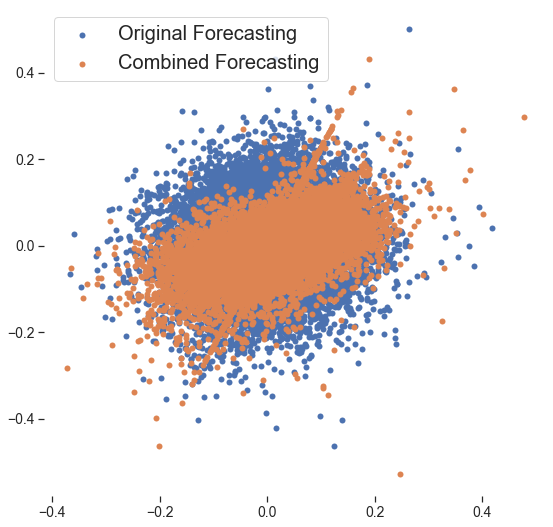

In [33]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(9, 9))

sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=dt1, x='er1', y='er2', palette="ch:r=-.2,d=.3_r", linewidth=0, ax=ax)
sns.scatterplot(data=dt2, x='er1', y='er2', palette="ch:r=-.2,d=.3_r", linewidth=0, ax=ax)
plt.tick_params(axis='both', which='major', labelsize=14)

a = plt.xlabel('', fontsize=20)
a = plt.ylabel('', fontsize=20)
plt.legend(labels=['Original Forecasting','Combined Forecasting'], fontsize=20)

#f.savefig('combined_result_error_comparison_lead.png', dpi=1000, bbox_inches="tight")

### Comparison of the proposed method and the case when the generation forecasting is only adopted

In [34]:
gentoram = np.zeros(gen_pred.shape)

for i in range(gentoram.shape[0]):
    for j in range(gentoram.shape[1]):
        if j==0:
            if i==0:
                gen0 = gen_real[0,0]-ram_real[0,0]/100
            else:
                gen0 = gen_real[i-1,0]   
        else:
            gen0 = gen_pred[i,j-1]
            
        gentoram[i,j] = (gen_pred[i,j]-gen0)*100
        
gentoram = gentoram.reshape(-1,1)

In [35]:
gentoram = std_scaler_ramp.transform(gentoram)

In [36]:
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram, ram_only), ' MAE == ', mae(real_ram, ram_only), 'MAPE == ', mape(real_ram, ram_only), ' MAEMS == ', maems(real_ram, ram_only))
print('Interpreted From Generation Forecasting Test Score > MSE == ', mse(real_ram, gentoram), ' MAE == ', mae(real_ram, gentoram), 'MAPE == ', mape(real_ram, gentoram), ' MAEMS == ', maems(real_ram, gentoram))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram, com_ram), ' MAE == ', mae(real_ram, com_ram), 'MAPE == ', mape(real_ram, com_ram), ' MAEMS == ', maems(real_ram, com_ram))

Ramp Rate Only Error Test Score > MSE ==  0.006923539538797043  MAE ==  0.06477371626877722 MAPE ==  13.22768778955179  MAEMS ==  1.7753867362004234
Interpreted From Generation Forecasting Test Score > MSE ==  0.004840290760930908  MAE ==  0.04673140613630243 MAPE ==  9.550925496443236  MAEMS ==  1.2864299264021517
Combined Ramp Rate Error Test Score > MSE ==  0.0036893242531762416  MAE ==  0.04499365674941617 MAPE ==  9.276073676649279  MAEMS ==  1.2268918146621395


In [37]:
gentoram2 = gentoram[(real_ram>0.8)|(real_ram<0.2)]

In [38]:
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram2, ram_only2), ' MAE == ', mae(real_ram2, ram_only2), 'MAPE == ', mape(real_ram2, ram_only2), ' MAEMS == ', maems(real_ram2, ram_only2))
print('Interpreted From Generation Forecasting Test Score > MSE == ', mse(real_ram2, gentoram2), ' MAE == ', mae(real_ram2, gentoram2), 'MAPE == ', mape(real_ram2, gentoram2), ' MAEMS == ', maems(real_ram2, gentoram2))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram2, com_ram2), ' MAE == ', mae(real_ram2, com_ram2), 'MAPE == ', mape(real_ram2, com_ram2), ' MAEMS == ', maems(real_ram2, com_ram2))

Ramp Rate Only Error Test Score > MSE ==  0.017140276821193085  MAE ==  0.10665985923217026 MAPE ==  23.79007672233428  MAEMS ==  6.271092624642533
Interpreted From Generation Forecasting Test Score > MSE ==  0.011841449385581798  MAE ==  0.07761517714421667 MAPE ==  16.497459398186926  MAEMS ==  4.631443801381523
Combined Ramp Rate Error Test Score > MSE ==  0.009256441403193316  MAE ==  0.07491772468075297 MAPE ==  18.006522383981864  MAEMS ==  4.239898436235081
